In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, atan, degrees

In [64]:
MAX_IMG_AREA = 2_500_000

def imshow(*imgs: cv2.Mat) -> None:
    def helper(img: cv2.Mat) -> None:
        plt.axis('off')
        plt.grid(False)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.show()
    for img in imgs:
        helper(img)

def imread_capped(filename: str) -> cv2.Mat:
    img = cv2.imread(filename)
    scale_factor = min(sqrt(MAX_IMG_AREA / (img.shape[0] * img.shape[1])), 1)
    return cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

def to_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def from_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR) 

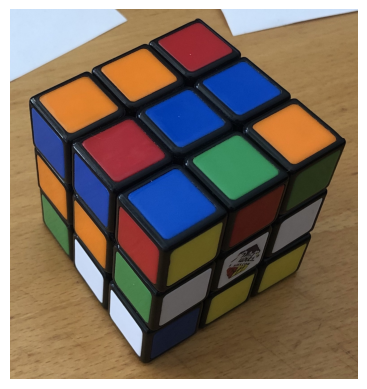

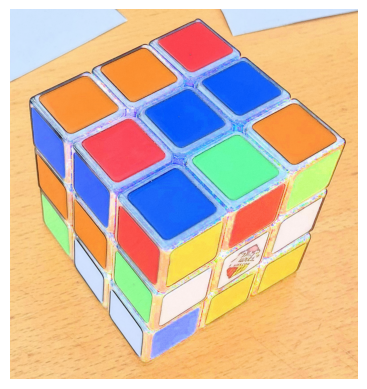

In [22]:
import cv2
import numpy as np


def remove_shadows(img: cv2.Mat):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img)
    # leave hue alone, modify the rest


    def process_channel(plane: np.ndarray):
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        return diff_img, norm_img
        
    new_h, norm_h = process_channel(h)
    new_s, norm_s = process_channel(s)
    new_v, norm_v = process_channel(v)

    result = cv2.merge([h, s, new_v])
    result_norm = cv2.merge([h, s, norm_v])

    return cv2.cvtColor(result_norm, cv2.COLOR_HSV2BGR)

img = cv2.imread("./images/cube_ugly.png")
imshow(img, remove_shadows(img))

Find the squares in which everything is

19 3


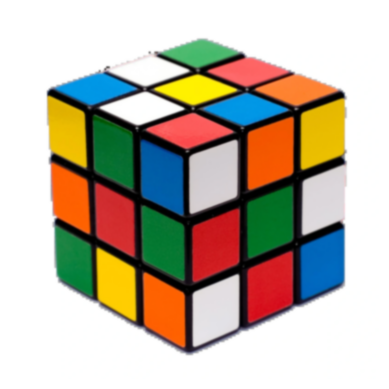

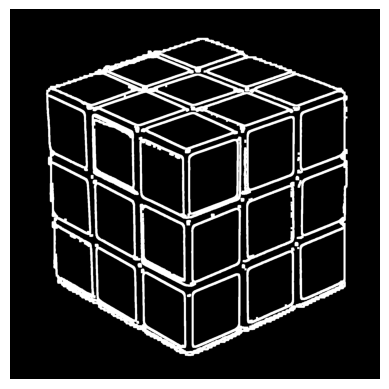

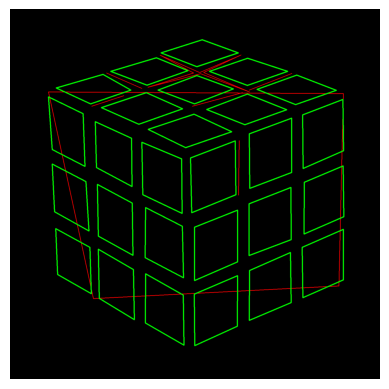

In [72]:
def filter_cubie_contours(img: cv2.Mat, contours: list[np.ndarray], approx: list[np.ndarray]) -> list[np.ndarray]:

    # filter erradic, non-quadrilateral contours
    proper_contours, proper_approx = [], []
    for cnt, appr in zip(contours, approx):

        # make sure the shape approximation is a quadrilateral 
        D = len(appr) * 2
        if not 8==D:  # lol
            continue

        # make sure the approx isnt crazy different area-wise - consider removing this test
        cnt_area = cv2.contourArea(cnt, True)
        ratio = cnt_area / cv2.contourArea(appr, True)
        if min(ratio, 1/ratio) < 0.80:   # artitrary ratio thresold chosen by me
            continue

        # make sure the overlapping area isnt too bad
        overlap_reference = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(overlap_reference, [cnt], -1, (255, 255, 255), cv2.FILLED)
        cv2.drawContours(overlap_reference, [appr], -1, (0, 0, 0), cv2.FILLED)
        if (overlap_reference.sum() // 255) > (cnt_area // 5):
            continue

        proper_contours.append(cnt) 
        proper_approx.append(appr)

    # sweep through it again and cut off the ones that are too small
    avg_area = np.average([*map(cv2.contourArea, proper_approx)])
    return [*filter(lambda x: cv2.contourArea(x) > avg_area / 4, proper_approx)]

def get_cubie_contours(img: cv2.Mat, show: bool = False) -> list[np.ndarray]:

    # computes some sizes
    # TODO: fix these, because they are too large when the image is smaller, and not large enough when the image is bigger
    reference_size = max(img.shape)
    blur_size = int(sqrt(reference_size) / 2)
    kernel_size = int(sqrt(reference_size) / 10)
    if show:
        print(blur_size, kernel_size)

    # image processing to get contours
    blur = cv2.GaussianBlur(img, (blur_size + int(blur_size % 2 == 0),) * 2, kernel_size)
    edges = cv2.Canny(blur, 20, 30)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size * 3,) * 2)
    dilated = cv2.dilate(edges, kernel)
    contours = sorted(cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, reverse=True)
    large_contours = [*filter(lambda x: cv2.contourArea(x, True) > (img.shape[0] * img.shape[1]) // 5000, contours)]
    approx = [*map(lambda x: cv2.approxPolyDP(x, 0.03*cv2.arcLength(x, True), True), large_contours)]
    
    # filter the contours, show if needed
    filtered = filter_cubie_contours(img, large_contours, approx)
    if show:
        display_image = np.zeros_like(img)
        cv2.drawContours(display_image, approx, -1, (0, 0, 255), 2)
        cv2.drawContours(display_image, filtered, -1, (0, 255, 0), 3)
        imshow(blur, dilated, display_image)
    return filtered, approx

img = imread_capped("./images/cube.png")
_ = get_cubie_contours(img, show=True)

Split the small cubies by face, in order to better determine where everything is - this works optimally when the cube has three faces on display, as all three have different angles.

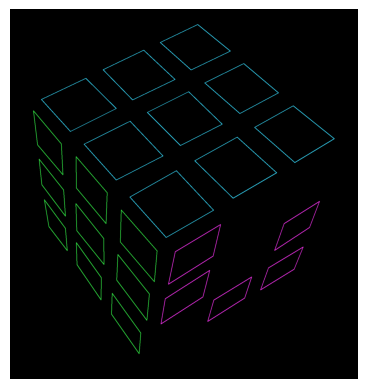

In [86]:
def get_squares_by_angle(squares: list[np.ndarray]):

    ANGLE_DIFF_TOLERANCE = 18   # degrees
    def compute_incline_angle(c1: np.ndarray[int, int], c2: np.ndarray[int, int]):
        """ Helper function to compute the angle between two corners. """
        x_diff, y_diff = map(abs, (c1[0] - c2[0], c1[1] - c2[1]))
        return degrees(atan(y_diff / x_diff))

    angle_to_squares = {}
    for appr in squares:
        appr = appr.reshape(appr.shape[0], 2)
        corner1, corner2, corner3 = appr[0], appr[1], appr[-1]
        angle_of_incline1 = compute_incline_angle(corner1, corner2)
        angle_of_incline2 = compute_incline_angle(corner3, corner1)
        for (k1, k2), v in angle_to_squares.items():
            if abs(angle_of_incline1 - k1) < ANGLE_DIFF_TOLERANCE and abs(angle_of_incline2 - k2) < ANGLE_DIFF_TOLERANCE:   
                v.append(appr)
                break
        else:
            angle_to_squares[(angle_of_incline1, angle_of_incline2)] = [appr]
    return angle_to_squares

img = imread_capped("./images/cube_ugly.png")
display_img = np.zeros_like(img)
for i, v in enumerate(get_squares_by_angle(get_cubie_contours(img, show=False)[0]).values()):
    colors = ((235, 204, 52), (226, 49, 232), (65, 217, 48), (0, 0, 200))
    cv2.drawContours(display_img, v, -1, colors[min(i, 3)], max(display_img.shape) // 1000 + 1)
imshow(display_img)

2583263

In [1]:
import time
img = cv2.imread("./images/cube_ugly.png")
blur = cv2.GaussianBlur(img, (21, 21), 5)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
imshow(*map(lambda x: cv2.bitwise_not(cv2.Canny(x, 20, 30)), [blur, gray]))

# start = time.perf_counter()
# edges = cv2.Canny(blur, 20, 30)
# end1 = time.perf_counter()
# thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 1)
# adjusted_thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
# end2 = time.perf_counter()
# imshow(cv2.bitwise_not(edges), adjusted_thresh)
# print(end1-start, end2-end1)

NameError: name 'cv2' is not defined

000001011110110010100010000000111110101001010100100100101000000000110000111010101010010111101110000000110100101010101101000000010110101001101100111100011100000000101010111001100010111010000000011110110010100010000000111000100000101011101111000000100110101010110110
000001011110110010100010000000111110101001010100100100101000000000110000111010101010010111101110000000110100101010101101000000010110101001101100111100011100000000101010111001100010111010000000011110110010100010000000111000100000101011101111000000100110101010110110
